# CNN + AE


## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Conv1D, Conv1DTranspose
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 필요 함수들 생성

#### 1) reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [2]:
def recon_err_plot(x, x_pred, y, threshold=0):
    mse = np.mean(np.power(x.reshape(x.shape[0], -1) - x_pred.reshape(x_pred.shape[0], -1), 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y})
    error_df = error_df.reset_index()

    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots(figsize=(15, 8))
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Break" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error plot")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.grid()
    plt.show()

    return error_df

#### 2) precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다. 
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [3]:
def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.figure(figsize = (12,8))

    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('Anomaly Score')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### 3) threshold로 잘랐을 때, 분류 평가 함수


In [4]:
def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

    return confusion_matrix(y, pred_temp)

#### 4) DL 학습곡선 그리기


In [5]:
def plot_learning_curve(history) :
    plt.figure(figsize = (10,6))
    plt.plot(history['loss'], label='Train', marker = '.')
    plt.plot(history['val_loss'], label='Validation', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

#### 5) 시계열 데이터 분석을 위한 데이터구조 만들기(for LSTM, CNN)

In [6]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        t = []
        for j in range(timestep):
            t.append(x[[(i + j)], :])
        output_X.append(t)
        output_y.append(y[i + timestep - 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

### (3) 데이터셋 불러오기

In [7]:
# 공정 데이터 불러오기
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/processminer2.csv"
data = pd.read_csv(path)
data.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0.0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0.0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0.0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0.0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105


## 2.데이터 준비

### (1) 불필요한 변수 제거

불필요한 변수 제거 : time

In [8]:
data.drop('time', axis=1, inplace=True)

In [9]:
data.shape

(18274, 60)

### (2) x,y 분할

* x, y 분리

In [10]:
target = 'y'
input_x = data.drop(target, axis = 1).values
input_y = data['y'].values

In [11]:
input_x.shape

(18274, 59)

### (3) 스케일링

In [12]:
scaler = MinMaxScaler()
input_x = scaler.fit_transform(input_x)

### (4) 3차원 데이터로 변환
* timestep에 맞게 data point를 2차원으로 변환  
(data point : 2차원 ==> data set : 3차원)

In [13]:
timestep = 10 
x, y = temporalize(input_x, input_y, timestep)

In [14]:
x.shape, y.shape

((18265, 10, 59), (18265,))

### (5) 데이터셋 분할

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=6000, random_state=20)

### (6) Normal 분리 : Normal 데이터로만 학습하기 위해서 

In [16]:
x_train0 = x_train[y_train==0]

## 3.모델링①



### (1) 모델링 : CNN + AE

In [17]:
timesteps =  x_train0.shape[1] # equal to the lookback
n_features =  x_train0.shape[2] # 59

In [18]:
clear_session()

cnn_ae1 = Sequential([Conv1D(32, 3, input_shape=(timesteps, n_features), 
                                activation='relu', padding = 'same'), 
                        Conv1D(16, 3, activation="relu", padding = 'same'),
                        Conv1DTranspose(16, 3, activation="relu", padding = 'same'),
                        Conv1DTranspose(32, 3, activation="relu", padding = 'same'),
                        Conv1DTranspose(n_features, 3, padding = 'same') ])

# # Encoder
# input_layer = Input(shape=(timesteps, n_features))
# encoder = Conv1D(32, 3, activation='relu', padding = 'same')(input_layer)
# encoder = Conv1D(16, 3, activation="relu", padding = 'same')(encoder)
# # Decoder
# decoder = Conv1DTranspose(16, 3, activation="relu", padding = 'same')(encoder)
# decoder = Conv1DTranspose(32, 3, activation="relu", padding = 'same')(decoder)
# decoder = Conv1DTranspose(n_features, 3, padding = 'same')(decoder)

# cnn_ae1 = Model(inputs=input_layer, outputs=decoder)

cnn_ae1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            5696      
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 16)            1552      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 10, 16)           784       
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 10, 32)           1568      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 10, 59)           5723      
 ranspose)                                                       
                                                        

In [ ]:
cnn_ae1.compile(loss='mse', optimizer='adam')

history = cnn_ae1.fit(x_train0, x_train0, epochs=50, batch_size=128
                        ,validation_split=.2).history

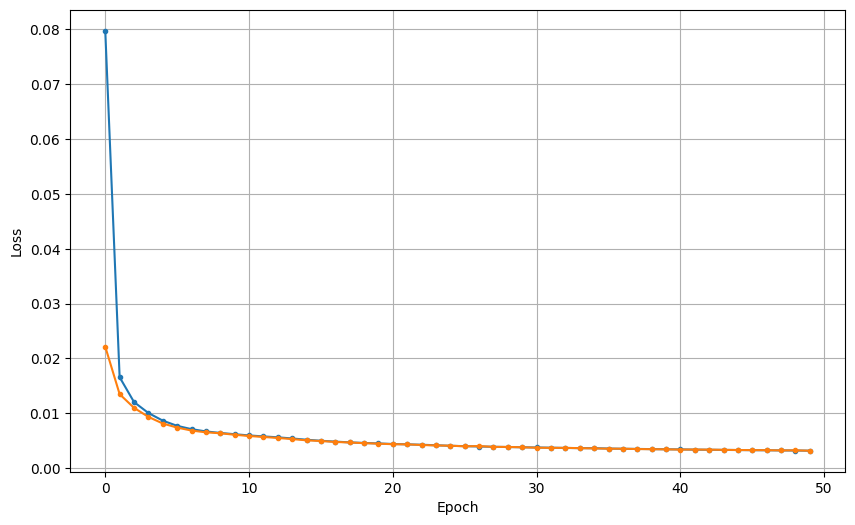

In [20]:
plot_learning_curve(history)

### (2) 분류에 대한 평가

* test 셋으로 예측하고 reconstruction error로 평가해 봅시다. (recon_err_plot2)

In [21]:
pred = cnn_ae1.predict(x_val)

188/188 [==============================] - 1s 2ms/step


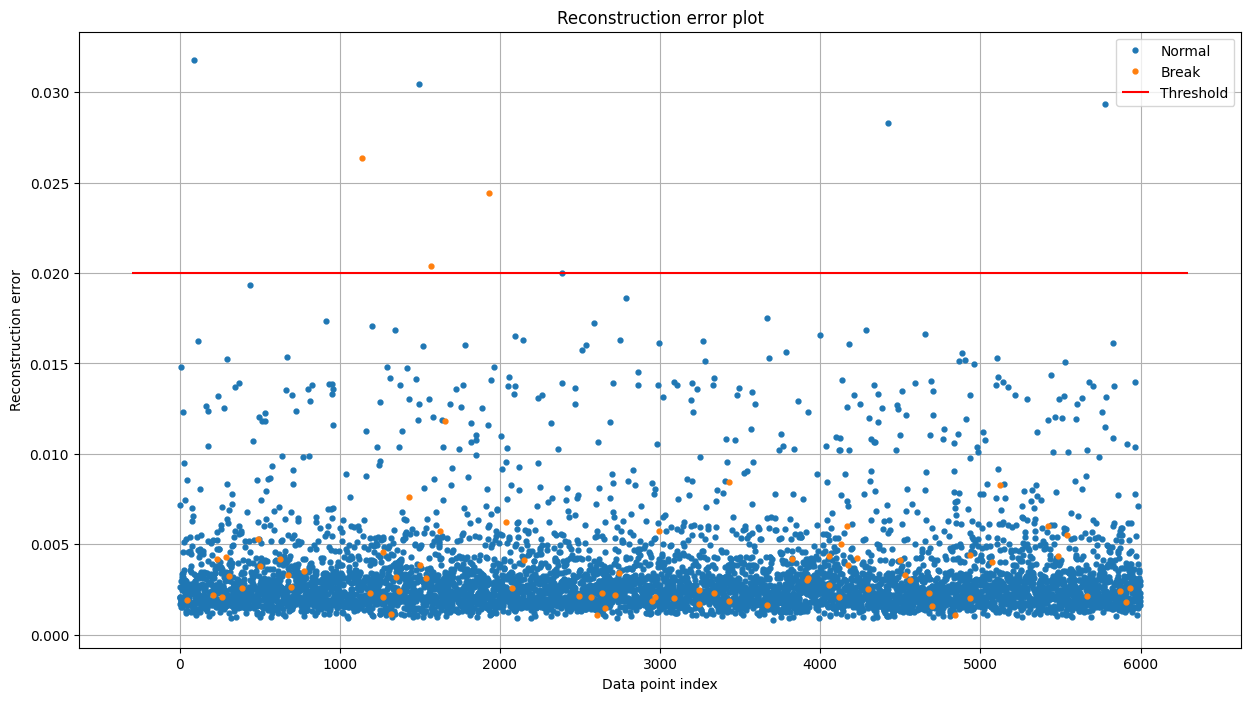

In [22]:
result = recon_err_plot(x_val, pred, y_val, .02)

* thresholds 값을 조절하면서, precision, recall, f1 score 그래프를 그려 봅시다.(prec_rec_f1_curve)

<ipython-input-3-bab5292dc7b7>:3: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


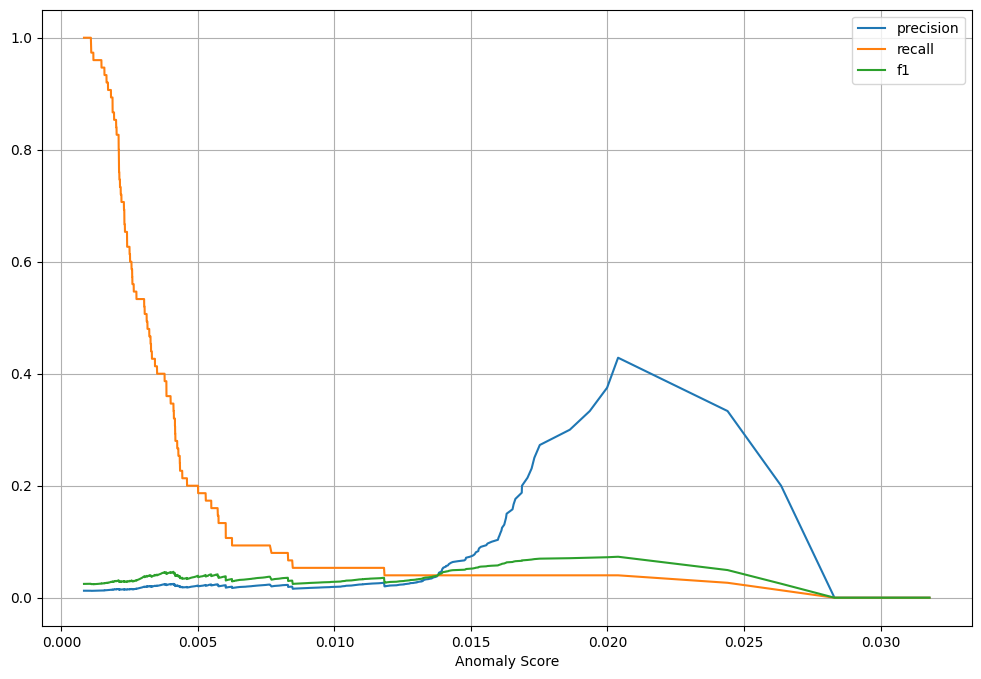

In [23]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

* f1 score를 가장 높이는 thresholds 값을 찾고 평가해 봅시다.

In [24]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.020387920104838652

In [25]:
cm1 = classification_report2(result['True_class'], result['Reconstruction_error'],thres_f1_max)

< confusion matrix >

[[5921    4]
 [  73    2]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5925
         1.0       0.33      0.03      0.05        75

    accuracy                           0.99      6000
   macro avg       0.66      0.51      0.52      6000
weighted avg       0.98      0.99      0.98      6000



## 4.모델링②
* 모델링 1을 참조로 구조를 변경해서 모델링 수행해 봅시다.

In [28]:
cnn_ae2 = Sequential([Conv1D(64, 5, input_shape=(timesteps, n_features), 
                                activation='relu', padding = 'same'), 
                        Conv1D(32, 5, activation="relu", padding = 'same'),
                        Conv1D(16, 5, activation="relu", padding = 'same'),

                        Conv1DTranspose(16, 5, activation="relu", padding = 'same'),
                        Conv1DTranspose(32, 5, activation="relu", padding = 'same'),
                        Conv1DTranspose(64, 5, activation="relu", padding = 'same'),
                        Conv1DTranspose(n_features, 5, padding = 'same') ])


In [29]:
cnn_ae2.compile(loss='mse', optimizer='adam')

history = cnn_ae2.fit(x_train0, x_train0, epochs=50, batch_size=128
                        ,validation_split=.2).history

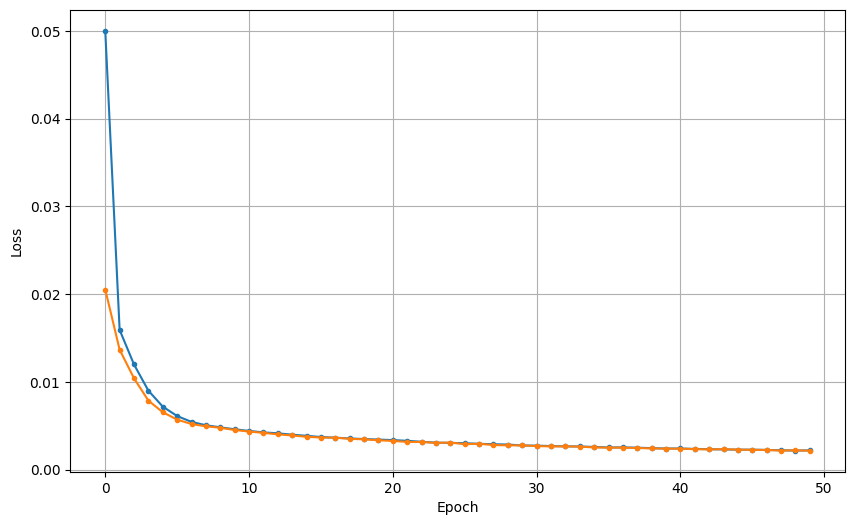

In [30]:
plot_learning_curve(history)

In [31]:
pred = cnn_ae2.predict(x_val)

188/188 [==============================] - 1s 4ms/step


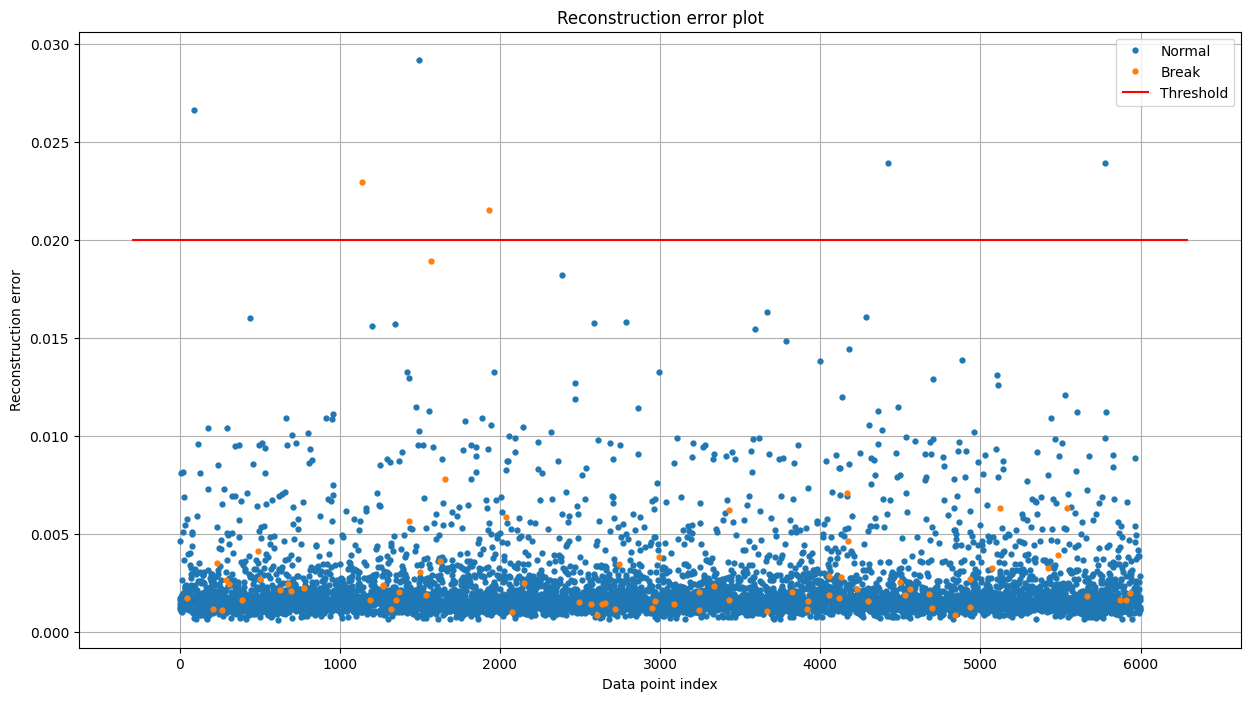

In [32]:
result = recon_err_plot(x_val, pred, y_val, .02)

* thresholds 값을 조절하면서, precision, recall, f1 score 그래프를 그려 봅시다.(prec_rec_f1_curve)

<ipython-input-3-bab5292dc7b7>:3: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


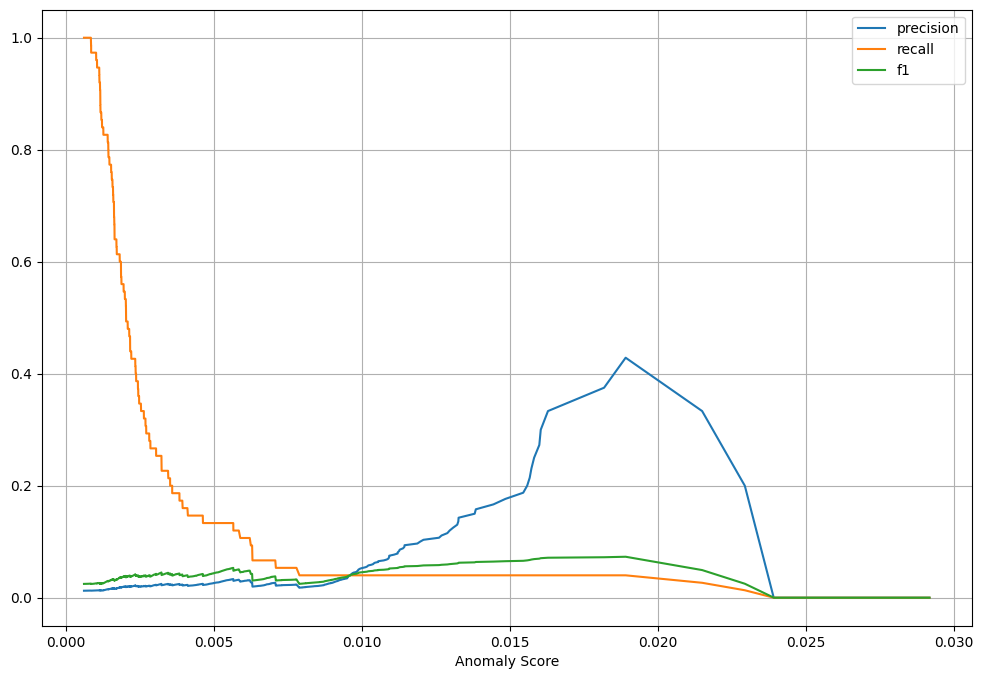

In [33]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

* f1 score를 가장 높이는 thresholds 값을 찾고 평가해 봅시다.

In [34]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.018913183889234353

In [35]:
cm1 = classification_report2(result['True_class'], result['Reconstruction_error'],thres_f1_max)

< confusion matrix >

[[5921    4]
 [  73    2]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5925
         1.0       0.33      0.03      0.05        75

    accuracy                           0.99      6000
   macro avg       0.66      0.51      0.52      6000
weighted avg       0.98      0.99      0.98      6000



* thresholds 값을 조절하면서, precision, recall, f1 score 그래프를 그려 봅시다.(prec_rec_f1_curve)

* f1 score를 가장 높이는 thresholds 값을 찾고 평가해 봅시다.